# Basic Anti-aliased Geological Models

I'm now going to use some of the ideas in the first notebook on anti-aliasing to develop a set of simple parametric geological models that have posteriors we can sample by MCMC.  They'll draw on ideas from several different kinds of models for best results, with what I hope will be structures transparent to both geologists and data scientists.

What we found earlier was that it was straightforward to anti-alias interfaces that were defined _implicitly_, by some function $\phi(\mathbf{x}) = 0$; the partial volume in a voxel along the interface could be expressed, to a very good approximation, as a function of the normal distance to that interface from the voxel center.  This is similar to the way interfaces are defined in the so-called _implicit_ class of models that include many packages our DARE collaborators are already working with, such as GemPy, GeoModeller, and LoopStructural.  The implicit functions these packages use are more abstract measures of geological time, rather than concrete measures like physical distance.  However, if we show that parametric anti-aliasing can work on simple models like the ones we will develop, it shouldn't be too far a step to technology that can work with real 3-D geological models.

One convenient and geologically sensible way to build a volume, though, is by composition, since in cases where multiple interfaces overlap it establishes a clear order of evaluation that resolves any interpretive ambiguities.  This is a feature of _kinematic_ models such as Noddy; LoopStructural also incorporates kinematic elements.

Let's first define an infinite-resolution geology as a composition of functions with implicitly defined interfaces; then blur out these interfaces with an anti-aliasing kernel, and evaluate on a grid for geophysics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from blockworlds import profile_timer, DiscreteGravity
from blockworlds import baseline_tensor_mesh, survey_gridded_locations

z0, L, NL = 0.0, 1000.0, 20
h = L/NL
print("z0, L, nL, h =", z0, L, NL, h)
mesh = baseline_tensor_mesh(NL, h, centering='CCN')
survey = survey_gridded_locations(L, L, 20, 20, z0)

z0, L, nL, h = 0.0 1000.0 20 50.0


I'm going to define a sequence of events here that generates something like the graben model shown in Figures 8 and 9 of Pakyuz-Charrier+ 2018.  This has several horizontal layers and two vertical faults running through them.

calc_gravity ran in 1.571 sec
calc_gravity ran in 0.002 sec
calc_gravity ran in 0.002 sec
calc_gravity ran in 0.002 sec
calc_gravity ran in 0.003 sec
calc_gravity ran in 0.004 sec


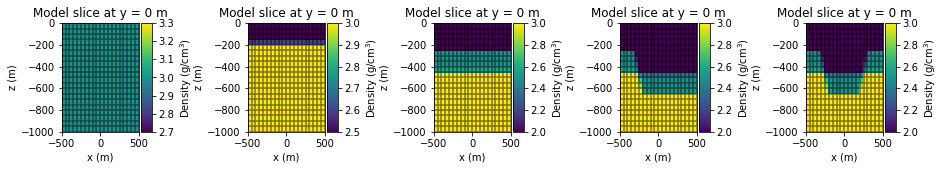

In [4]:
from implicit import GeoFunc, Basement, StratigraphicLayer, PlanarFault

# Define the geology as a list of chained events
history = [Basement()]
history.append(StratigraphicLayer(history[-1]))
history.append(StratigraphicLayer(history[-1]))
history.append(PlanarFault(history[-1]))
history.append(PlanarFault(history[-1]))
# Basement density (g/cc)
histpars = [3.0]
# Thicknesses (m) and densities (g/cc) for overlying stratigraphic layers
histpars.extend([190.0, 2.5, 250.0, 2.0])
# Fault #1:  anchor point r0[x,y,z] (m), normal n[x,y,z], slip (m)
histpars.extend([-400.0, 0.0, 0.0, 0.950, 0.0, 0.312, -220.0])
# Fault #2:  anchor point r0[x,y,z] (m), normal n[x,y,z], slip (m)
histpars.extend([+400.0, 0.0, 0.0, 0.950, 0.0, -0.312, 220.0])
# Define the forward model
fwdmodel = DiscreteGravity(mesh, survey, history[0])
fwdmodel.gfunc = Basement()
fwdmodel.edgemask = profile_timer(fwdmodel.calc_gravity, h, [1.0])
# Show a sequence of how the model is built up
fig1 = plt.figure(figsize=(15, 2))
for m, part_history in enumerate(history):
    fwdmodel.gfunc = part_history
    npars = np.sum([e.npars for e in history[:m+1]])
    profile_timer(fwdmodel.calc_gravity, h, histpars[:npars])
    fwdmodel.fwd_data -= fwdmodel.edgemask * fwdmodel.voxmodel.mean()
    ax = plt.subplot(1, 5, m+1)
    fwdmodel.plot_model_slice(ax=ax)
plt.subplots_adjust(wspace=1.0)
plt.show()

The engineering on this is pretty clunky right now; obviously it needs to be cleaned up and encapsulated.  But hopefully you can see what we're doing:  the Basement class provides a background density that is then perturbed in sequence by adding and transforming layers.  I've implemented it recursively:  we start by evaluating the latest event, each of which calls the event before it to figure out what it's perturbing.  Here's a peek into the code for the PlanarFault class:

In [5]:
"""
class PlanarFault(GeoFunc):

    def __init__(self, base_gfunc):
        super().__init__(7, base_gfunc)

    def __call__(self, r, h, p):
        r0, n, s = p[-7:-4], p[-4:-1], p[-1]
        v = np.cross(np.cross([0, 0, 1], n), n)
        rdelt = s * v/l2norm(v)
        g0 = self.base_gfunc(r, h, p[:-7])
        g1 = self.base_gfunc(r + rdelt, h, p[:-7])
        return soft_if_then(np.dot(r-r0, n), g0, g1, h)
"""

The base class, GeoFunc, has as attributes some number of parameters and a "base geology" that it acts upon, which is a chained hook for some other GeoFunc.  When called, PlanarFault first works out the placement and kinematics of the fault; then evaluates the base geology on either side of the fault; and finally performs the anti-aliasing step.

Unfortunately I've overlooked something important:  _all_ the anti-aliasing has to be done at the end, or else each step will be working on a downsampled version of the step before it and we're likely to run into trouble.  I don't think it will make much difference for this particular geology because the worst of the resampling effects should be localized along the two faults, which don't intersect.  But for even slightly more complex geologies this could quickly get out of hand.